In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import info_map
from scripts.arena import Arena, Aperture, Mouse, visualize_arena
from tqdm import tqdm
import os
from scipy.interpolate import interp1d

BASE_PATH = "/Users/reecekeller/Documents/Xaq/act_sense/act_sense/data/"

In [42]:
def get_visibility(source, target, aperture):
    v_t2Lwall = np.subtract(aperture.left_wall_edge + (target[2],), target)
    v_t2Lwall = v_t2Lwall/np.linalg.norm(v_t2Lwall)
    v_t2Rwall = np.subtract(aperture.right_wall_edge + (target[2],), target)
    v_t2Rwall = v_t2Rwall/np.linalg.norm(v_t2Rwall)

    # Vector from target to source (normalized)
    v_t2s = np.subtract(source, target)
    v_t2s = v_t2s / np.linalg.norm(v_t2s)

    # Cross products to determine the relative position of v_target2source
    cross_LS = np.cross(v_t2Lwall[:2], v_t2s[:2])
    cross_RS = np.cross( v_t2s[:2], v_t2Rwall[:2],)
    # Check if v_target2source is between the left and right wall vectors

    if cross_LS >=0 and cross_RS >=0:
        return True
    else:
        return False


def get_visible_angles(source, circle_center, radius, aperture):
    """
    Calculate the visible area of a circle from a given point by checking the visibility
    of various points on the circle's perimeter.
    """
    d_theta = np.pi/180  # Increase for higher accuracy
    angles = np.arange(0, 2 * np.pi, d_theta)
    visible_angles = []
    
    for i in range(len(angles)-1):
        # Parametrize the circle
        x_circle = circle_center[0] + radius * np.cos(angles[i])
        z_circle = circle_center[2] + radius * np.sin(angles[i])
        y_circle = circle_center[1]  # Y remains the same for a circle in the YZ plane
        
        circle_point = (x_circle, y_circle, z_circle)
        flag = get_visibility(source, circle_point, aperture)
        if flag:
            visible_angles.append(angles[i])
    #print(len(angles), len(visible_angles))
    #area  = get_segment_area(visible_angles, radius)
    return visible_angles

def get_segment_area(angles, radius):
    if len(angles)==0:
        return (0, 0)
    else:
        # Sort the angles
        angles = np.sort(angles)
        # Calculate the differences between consecutive angles
        if (0 in angles):
            diffs = np.diff(angles, append=angles[-1]-angles[0])# + 2 * np.pi - angles[-1])
        else:
            diffs = np.abs(np.diff(angles, append=angles[0]))
        # Find the largest gap, which is the central angle of the segment
        central_angle = np.max([np.max(diffs), np.min(diffs)])
        #print(central_angle)
        # Calculate the area of the circular segment
        # Area of segment = 0.5 * radius^2 * (theta - sin(theta))
        area = 0.5 * radius**2 * (central_angle - np.sin(central_angle))

        # area compliment 
        area_c = np.abs(np.pi*radius**2 - area)
        return np.array([area, area_c])

def infoMetric(area1, area2):
    return 0.5 * np.abs(area1 + area2)

def info_map(arena, circle1_center, circle2_center, aperture, radius):
    x_resolution = arena.width
    y_resolution = arena.length - 10

    x = np.linspace(0, x_resolution, x_resolution)
    y = np.linspace(0, y_resolution, y_resolution)

    info_mat = np.zeros((x_resolution, y_resolution))
    print(info_mat.shape, '\n')
    # Iterate through a grid of points in the arena
    for i in tqdm(range(x_resolution)):
        for j in range(y_resolution):
            source = (x[i], y[j], 20)
            visible_anglesL = get_visible_angles(source, circle1_center, radius, aperture)
            visible_anglesR = get_visible_angles(source, circle2_center, radius, aperture)

            area_circle1 = get_segment_area(visible_anglesL, radius)
            area_circle2 = get_segment_area(visible_anglesR, radius)

            # Check whether to use major or minor segment area

            # larger element of area_circle is last element
            if len(visible_anglesL) > 180:
                A1 = np.max(area_circle1)
            elif len(visible_anglesL) <= 180: 
                A1 = np.min(area_circle1)
            if len(visible_anglesR) > 180:
                A2 = np.max(area_circle2)
            elif len(visible_anglesR) <= 180:
                A2 = np.min(area_circle2)
            # if source[0] > arena.length/2:
            #     A1 = np.max(area_circle1)
            #     A2 = np.min(area_circle2)
            # elif source[0] < arena.length/2:
            #     A1 = np.min(area_circle1)
            #     A2 = np.max(area_circle2)
            # else: 
            #     A1 = area_circle1[0]
            #     A2 = area_circle2[0]    
            d_left = np.linalg.norm(np.subtract(source, circle1_center))
            d_right = np.linalg.norm(np.subtract(source, circle2_center))

            info_mat[i, j] = infoMetric(A1/np.power(d_left, 1/3), A2/np.power(d_right, 1/3)) 
    return info_mat


def get_matrix_positions(data):
    grid_points = {key: [] for key in data.keys()}  # Creates a unique empty list for each key
    for p in data.keys():
        x_points, y_points = np.ceil(data[p])
        for x, y in zip(x_points, y_points):
            if (x, y) not in grid_points[p]:
                grid_points[p].append((int(x), int(y)))
    return grid_points

def integrate_info_path(data, info_map):
    p_int = {}
    coords = get_matrix_positions(data)
    for p in coords.keys():
        sum = 0
        for i, j in coords[p]:
            sum += info_map[j, i]
        p_int[p] = sum
    p_int = normalize_dict(p_int)
    return p_int

def integrate_path(data):
    p_int = {}
    for p in data.keys():
        p_int[p] = np.sum(np.sqrt(np.diff(data[p][0])**2 + np.diff(data[p][1])**2))
    p_int = normalize_dict(p_int)
    return p_int

def normalize_dict(p_dict):
    factor=1.0/sum(p_dict.values())
    for k in p_dict:
        p_dict[k] = p_dict[k]*factor
    return p_dict

def get_optimal_p(p_info, p_dist):
    p_sum = np.array(list(p_info.values())) - np.array(list(p_dist.values()))
    p_idx = np.argmax(p_sum)
    return list(p_info.keys())[p_idx]

def plot_trade_off(p_info_sum, p_dist_sum):
  for i, p in enumerate(p_info_sum.keys()):
      if i == 0:
        plt.scatter(p, p_info_sum[p], c='m', label='total information')
        plt.scatter(p, p_dist_sum[p], c='b', label='total distance')
      plt.scatter(p, p_info_sum[p], c='m')
      plt.scatter(p, p_dist_sum[p], c='b')

  plt.xlabel('p')
  plt.title('Distance/Information Trade off')
  plt.grid()
  plt.legend()

  import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L-p norm curve in the first quadrant
def lp_curve_scaled(p, num_points=10000, start=(30, 0), end=(60, 50)):
    # Generate angles for the first quadrant (0 to pi/2)
    theta = np.linspace(0, np.pi / 2, num_points)
    
    # Parametrize x and y using the Lp norm equation (r=1, for simplicity)
    x = np.cos(theta)
    y = np.sin(theta)
    
    # Transform to Lp norm by raising to power of p and normalizing
    x_lp = np.sign(x) * (np.abs(x) ** (2 / p))
    y_lp = np.sign(y) * (np.abs(y) ** (2 / p))
    
    # Normalize to satisfy the equation |x|^p + |y|^p = 1^p
    norm_factor = (np.abs(x_lp) ** p + np.abs(y_lp) ** p) ** (1 / p)
    x_lp /= norm_factor
    y_lp /= norm_factor
    
    # Scale to the target size
    start_x, start_y = start[0], end[1]
    end_x, end_y = end[0], start[1]
    
    # Compute scaling factors
    scale_x = end_x - start_x
    scale_y = end_y - start_y
    
    # Scale the points
    x_scaled = x_lp * scale_x + start_x
    y_scaled = y_lp * scale_y + start_y
    distances = np.sqrt(np.diff(x_scaled)**2 + np.diff(y_scaled)**2)
    cumulative_distances = np.concatenate([[0], np.cumsum(distances)])
    
    # Create interpolation functions for x and y based on arc length
    uniform_distances = np.linspace(0, cumulative_distances[-1], num_points)
    x_uniform = interp1d(cumulative_distances, x_scaled)(uniform_distances)
    y_uniform = interp1d(cumulative_distances, y_scaled)(uniform_distances)
    
    return x_uniform, y_uniform

# Plot Lp curves for different p with start at (30, 0) and end at (60, 50)
def plot_overlay(p_values, info_map, start=(30, 0), end1=(60, 50), end2 = (60, 50)):
    plt.figure(figsize=(8, 8))
    plt.imshow(info_map, cmap = 'viridis')
    plt.colorbar().set_label('Information')

    colors = plt.cm.Oranges(np.linspace(0, 1, len(p_values)))  # You can choose other colormaps

    for i, p in enumerate(p_values):
        color = colors[i]
        x_scaled1, y_scaled1 = lp_curve_scaled(p, num_points=100, start=start, end=end1)
        x_scaled2, y_scaled2 = lp_curve_scaled(p, num_points = 100, start=start, end=end2)
        plt.plot(x_scaled1, y_scaled1, color=color, label=f'p={p}')        
        plt.plot(x_scaled2, y_scaled2, color=color)

    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Scaled L-p Curves')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper left')
    plt.show()


def get_lp_data(p_values, start=(30, 0), end1=(60, 50), end2 = (60, 50)):
    data = {}

    for p in p_values:
        x_scaled1, y_scaled1 = lp_curve_scaled(p, start=start, end=end1)
        x_scaled2, y_scaled2 = lp_curve_scaled(p, start=start, end=end2)

        data[p]=np.array([x_scaled1, y_scaled1])
    
    return data


In [40]:
arena_length = 60
arena_width = 60
arena = Arena(length=arena_length, width=60, height=50)

res = 0.25
widths = np.arange(5, 15 + res, res)
p_values = [1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7.5, 10]  # Different p values for L-p norms



In [41]:
for w in tqdm(widths):
    aperture = Aperture(arena_width=arena_width, arena_height=50, arena_length=arena_length, gap_width=w)
    circleL = (arena.width/2 - 10, arena.width, arena.height/2)
    circleR = (arena.width/2 + 10, arena.width, arena.height/2)
    info_mat = info_map(arena, circleL, circleR, aperture, radius=5)
    np.save(os.path.join(BASE_PATH, f'info_matrix_{w}.npy'), info_mat)

  0%|          | 0/41 [00:00<?, ?it/s]

(60, 50) 



  2%|▏         | 1/41 [03:39<2:26:05, 219.14s/it]

(60, 50) 



  5%|▍         | 2/41 [07:46<2:33:18, 235.87s/it]

(60, 50) 



  5%|▍         | 2/41 [09:31<3:05:41, 285.67s/it]


KeyboardInterrupt: 

In [30]:
aperture_dict = {}
for w in widths:
    aperture_dict[w] = np.load(BASE_PATH + f'info_matrix_{w}.npy')


In [25]:
aperture = Aperture(arena_width=arena_width, arena_height=50, arena_length=arena_length, gap_width=10)
circleL = (arena.width/2 - 10, arena.width, arena.height/2)
circleR = (arena.width/2 + 10, arena.width, arena.height/2)
info_mat = info_map(arena, circleL, circleR, aperture, radius=5)
np.save(os.path.join(BASE_PATH, f'info_matrix_10.npy'), info_mat)

(60, 50) 



100%|██████████| 60/60 [03:36<00:00,  3.61s/it]


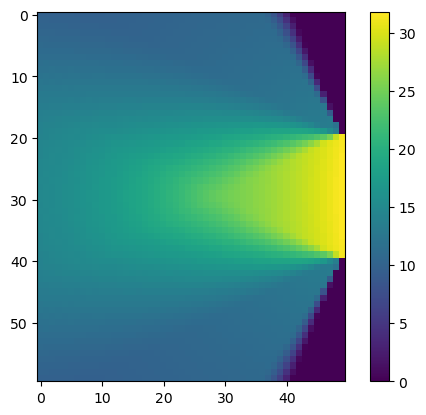

In [27]:
I = np.load(BASE_PATH + f'info_matrix_10.npy')
plt.imshow(I)
plt.colorbar()
plt.show()

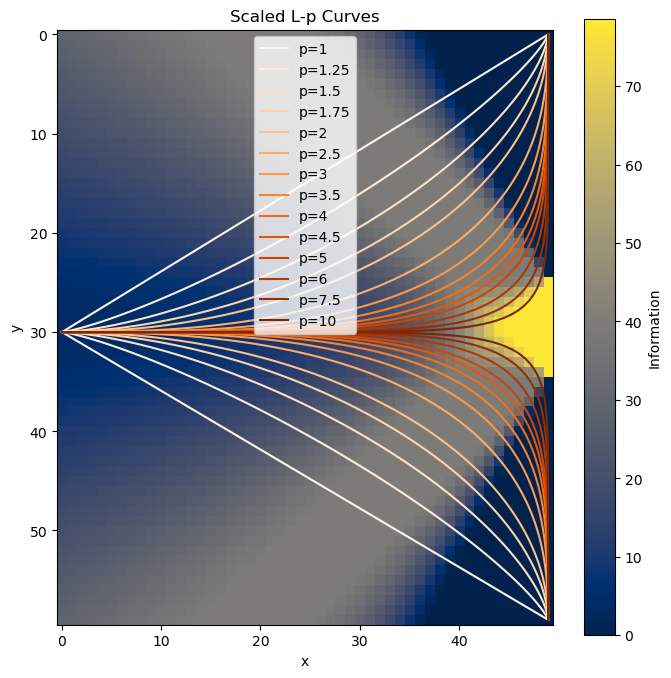

In [ ]:

# Plot the L-p curves starting at (30, 0) and ending at (60, 50)
plot_overlay(p_values, info_map_10, start=(0, 30), end1=(49, 0), end2=(49, 59))

In [9]:
data=get_lp_data(p_values, start=(0, 30), end1=(49, 0), end2=(49, 59))

In [ ]:
data.keys()

dict_keys([1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7.5, 10])

{5: 10, 6: 10, 7: 7.5, 8: 7.5, 9: 5, 10: 4, 11: 3, 12: 2, 13: 1.75, 14: 1.5, 15: 1.25}


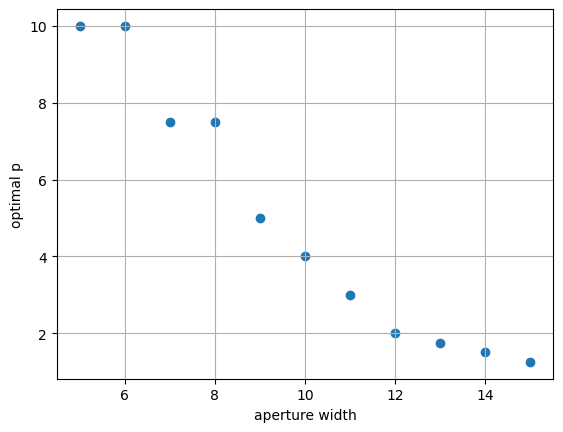

In [31]:
p_dist_sum = integrate_path(data)
p_dist_sum = normalize_dict(p_dist_sum)
optimal_p = {}
for w in aperture_dict.keys():
    p_info_sum = integrate_info_path(data, aperture_dict[w])
    optimal_p[w]=get_optimal_p(p_info_sum, p_dist_sum)
plt.scatter(optimal_p.keys(), optimal_p.values())
plt.xlabel('aperture width')
plt.ylabel('optimal p')
plt.grid(True)

print(optimal_p)

In [17]:
aperture_dict.keys(14.78=)

dict_keys([5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75])

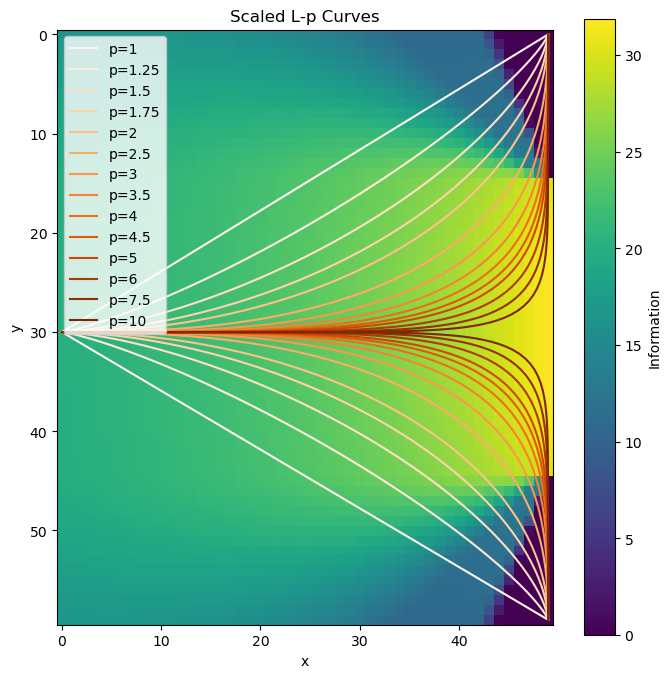

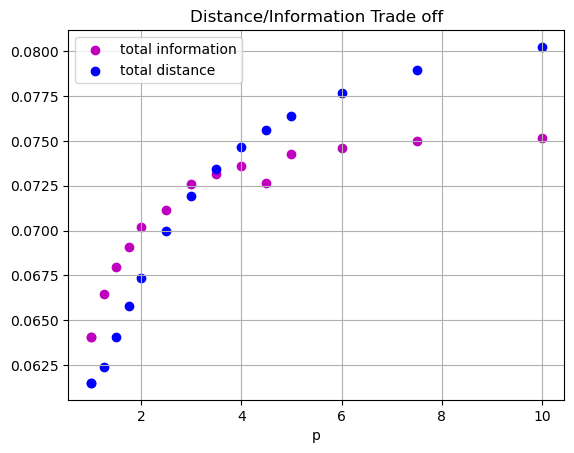

In [46]:
info_mat = aperture_dict[15] #aperture finer grain, radius scaling. 

_ = plot_overlay(p_values, info_mat, start=(0, 30), end1=(49, 0), end2=(49, 59))
p_info_sum = integrate_info_path(data, info_mat)
p_dist_sum = integrate_path(data)
plot_trade_off(p_info_sum, p_dist_sum)

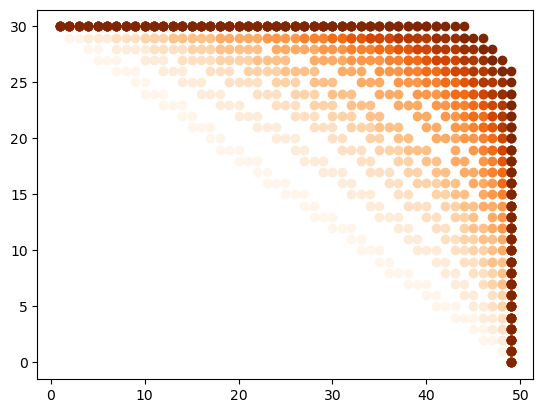

In [19]:
coords = get_matrix_positions(data)
colors = plt.cm.Oranges(np.linspace(0, 1, len(p_values)))  # You can choose other colormaps

for i, j in enumerate(p_values):
    c = colors[i]
    for x, y in coords[j]:
        plt.scatter(x, y, color = c)

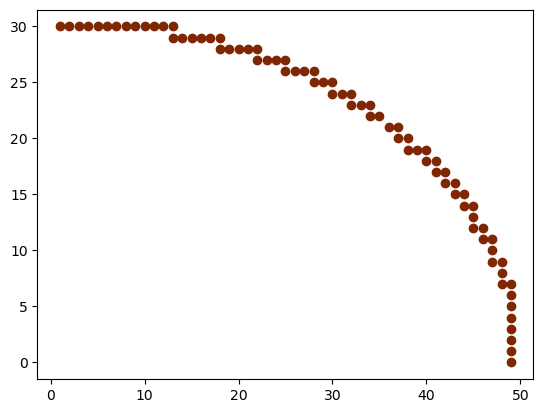

In [ ]:
coords = get_matrix_positions(data)

for x, y in coords[2]:
    plt.scatter(x, y, color = c)

In [ ]:
len(coords[7.5])
coords[1]

[(49, 0),
 (49, 1),
 (48, 1),
 (48, 2),
 (47, 2),
 (46, 2),
 (46, 3),
 (45, 3),
 (45, 4),
 (44, 4),
 (43, 4),
 (43, 5),
 (42, 5),
 (41, 5),
 (41, 6),
 (40, 6),
 (40, 7),
 (39, 7),
 (38, 7),
 (38, 8),
 (37, 8),
 (36, 8),
 (36, 9),
 (35, 9),
 (35, 10),
 (34, 10),
 (33, 10),
 (33, 11),
 (32, 11),
 (32, 12),
 (31, 12),
 (30, 12),
 (30, 13),
 (29, 13),
 (28, 13),
 (28, 14),
 (27, 14),
 (27, 15),
 (26, 15),
 (25, 15),
 (25, 16),
 (24, 16),
 (23, 16),
 (23, 17),
 (22, 17),
 (22, 18),
 (21, 18),
 (20, 18),
 (20, 19),
 (19, 19),
 (18, 19),
 (18, 20),
 (17, 20),
 (17, 21),
 (16, 21),
 (15, 21),
 (15, 22),
 (14, 22),
 (14, 23),
 (13, 23),
 (12, 23),
 (12, 24),
 (11, 24),
 (10, 24),
 (10, 25),
 (9, 25),
 (9, 26),
 (8, 26),
 (7, 26),
 (7, 27),
 (6, 27),
 (5, 27),
 (5, 28),
 (4, 28),
 (4, 29),
 (3, 29),
 (2, 29),
 (2, 30),
 (1, 30)]

In [ ]:
data[1][0]

array([4.90000000e+01, 4.89998789e+01, 4.89995154e+01, 4.89989097e+01,
       4.89980617e+01, 4.89969714e+01, 4.89956389e+01, 4.89940641e+01,
       4.89922471e+01, 4.89901879e+01, 4.89878865e+01, 4.89853429e+01,
       4.89825572e+01, 4.89795294e+01, 4.89762594e+01, 4.89727475e+01,
       4.89689935e+01, 4.89649975e+01, 4.89607596e+01, 4.89562797e+01,
       4.89515580e+01, 4.89465945e+01, 4.89413893e+01, 4.89359423e+01,
       4.89302537e+01, 4.89243235e+01, 4.89181517e+01, 4.89117385e+01,
       4.89050838e+01, 4.88981878e+01, 4.88910505e+01, 4.88836720e+01,
       4.88760524e+01, 4.88681916e+01, 4.88600900e+01, 4.88517474e+01,
       4.88431639e+01, 4.88343398e+01, 4.88252750e+01, 4.88159696e+01,
       4.88064237e+01, 4.87966375e+01, 4.87866110e+01, 4.87763443e+01,
       4.87658376e+01, 4.87550909e+01, 4.87441043e+01, 4.87328779e+01,
       4.87214119e+01, 4.87097064e+01, 4.86977614e+01, 4.86855772e+01,
       4.86731537e+01, 4.86604912e+01, 4.86475898e+01, 4.86344496e+01,
      

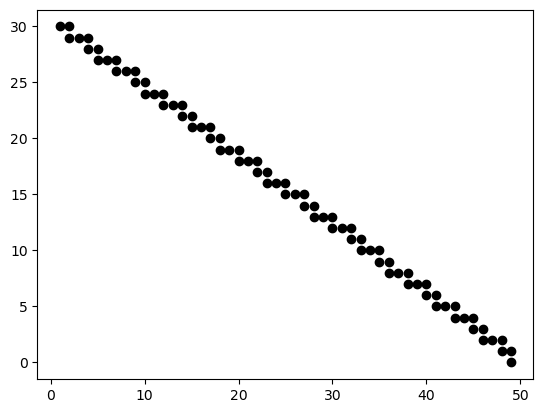

In [ ]:
for x, y in coords[1]:
    plt.scatter(x, y, color='k')

In [ ]:
integrate_info_path(data, info_map_15)

{1: 0.07359809230173481,
 1.25: 0.07439422914067907,
 1.5: 0.07334614959914303,
 1.75: 0.07447944837085754,
 2: 0.07352756379743776,
 2.5: 0.07313960493811868,
 3: 0.07352838445940989,
 3.5: 0.07213260744793848,
 4: 0.0744594657527107,
 4.5: 0.07213260744793848,
 5: 0.07213260744793848,
 6: 0.06864231999078015,
 7.5: 0.06515203253362183,
 10: 0.059334886771691284}

In [ ]:
p_info_sum = integrate_info_path(data, info_map_15)
p_dist_sum = integrate_path(data)
print(p_info_sum)
#get_optimal_p(p_info_sum, p_dist_sum)
#print(np.argmax(list(p_info_sum.values())))

{1: 0.07359809230173481, 1.25: 0.07439422914067907, 1.5: 0.07334614959914303, 1.75: 0.07447944837085754, 2: 0.07352756379743776, 2.5: 0.07313960493811868, 3: 0.07352838445940989, 3.5: 0.07213260744793848, 4: 0.0744594657527107, 4.5: 0.07213260744793848, 5: 0.07213260744793848, 6: 0.06864231999078015, 7.5: 0.06515203253362183, 10: 0.059334886771691284}
